##Analisis Sentimen Destinasi Wisata di Indonesia Berdasarkan Ulasan Wisatawan Mancanegara Menggunakan Algoritma **Naive Bayes**

**Anggota Kelompok:**
- Mahmuddin
- Achmad Ali Akbar
- Baso Muchtar Fajar Alghifari

**Sumber Data:**  
*IntrepidTravel.com*

In [9]:
import pandas as pd

# Baca Data dari dataset
df = pd.read_csv('dataset/intrepidtavel.csv', header=None, skiprows=1, quotechar='"', encoding='utf-8')

df_cleaned = df[df[3].notnull()]  # Hapus baris dengan komentar kosong
df_cleaned = df_cleaned[[3]]      # Ambil hanya kolom komentar
df_cleaned.columns = ['komen']    # Ganti nama kolom jadi 'komen'
df_cleaned.insert(0, 'id', range(1, len(df_cleaned) + 1))  # Tambahkan kolom ID

# Simpan ke file CSV baru
df_cleaned.to_csv('dataset/dataintrepidtravel.csv', index=False, encoding='utf-8')

print("Komentar berhasil disimpan ke dataintrepidtravel.csv")


Komentar berhasil disimpan ke dataintrepidtravel.csv


In [10]:
import pandas as pd
import re
import emoji
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

In [ ]:
# Baca Data dari dataset
data = pd.read_csv('dataset/dataintrepidtravel.csv', quotechar='"', encoding='utf-8')
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = emoji.replace_emoji(text, replace='')        # Hapus emoji
    text = text.lower()                                 # Case folding
    text = re.sub(r"http\S+|www.\S+", "", text)         # Hapus URL
    text = re.sub(r"\d+", "", text)                     # Hapus angka
    text = re.sub(r"[^\w\s]", "", text)                 # Hapus tanda baca
    text = re.sub(r"[^a-z\s]", "", text)                # Hapus karakter non-alfabet
    text = re.sub(r"\s+", " ", text).strip()            # Hapus spasi berlebih
    return text

# Fungsi normalisasi dengan contractions
def normalize_text(text):
    if pd.isnull(text):
        return ""
    return contractions.fix(text)

# Fungsi tokenisasi
def tokenize_text(text):
    if pd.isnull(text):
        return []
    return word_tokenize(text)

# Fungsi stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# Fungsi konversi POS tag NLTK ke format WordNet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default ke NOUN

# Lemmatization dengan POS
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    tagged_tokens = pos_tag(tokens)  # POS tagging
    return [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]

data['komen'] = data['komen'].apply(clean_text)
data["komen"] = data["komen"].apply(normalize_text)
data['komen'] = data["komen"].apply(tokenize_text)
data["komen"] = data["komen"].apply(remove_stopwords)
data['komen'] = data['komen'].apply(lemmatize_tokens)
data['komen'] = data['komen'].apply(lambda x: ' '.join(x))

# Simpan ke file baru
data.to_csv('dataset/datacleanintrepidtravel.csv', index=False, encoding='utf-8')

print("Cleaning selesai! File disimpan sebagai 'datacleanintrepidtravel.csv'")


Cleaning selesai! File disimpan sebagai 'datacleanintrepidtravel.csv'


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

data = pd.read_csv('dataset/datacleanintrepidtravel.csv')

analyzer = SentimentIntensityAnalyzer()

#Fungsi untuk pelabelan
def get_sentiment_label(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

#Menambahkan label pada data
data['label'] = data['komen'].apply(get_sentiment_label)

# Hitung jumlah masing-masing kelas sentimen
label_counts = data['label'].value_counts()

print("Jumlah data tiap kelas sentimen:")
print(label_counts)

data.to_csv('dataset/datalabelintrepidtravel.csv', index=False, encoding='utf-8')

print("Pelabelan selesai! File disimpan sebagai 'datalabelintrepidtravel.csv'")

Jumlah data tiap kelas sentimen:
label
positive    1006
neutral       26
negative      11
Name: count, dtype: int64
Pelabelan selesai! File disimpan sebagai 'datalabelintrepidtravel.csv'


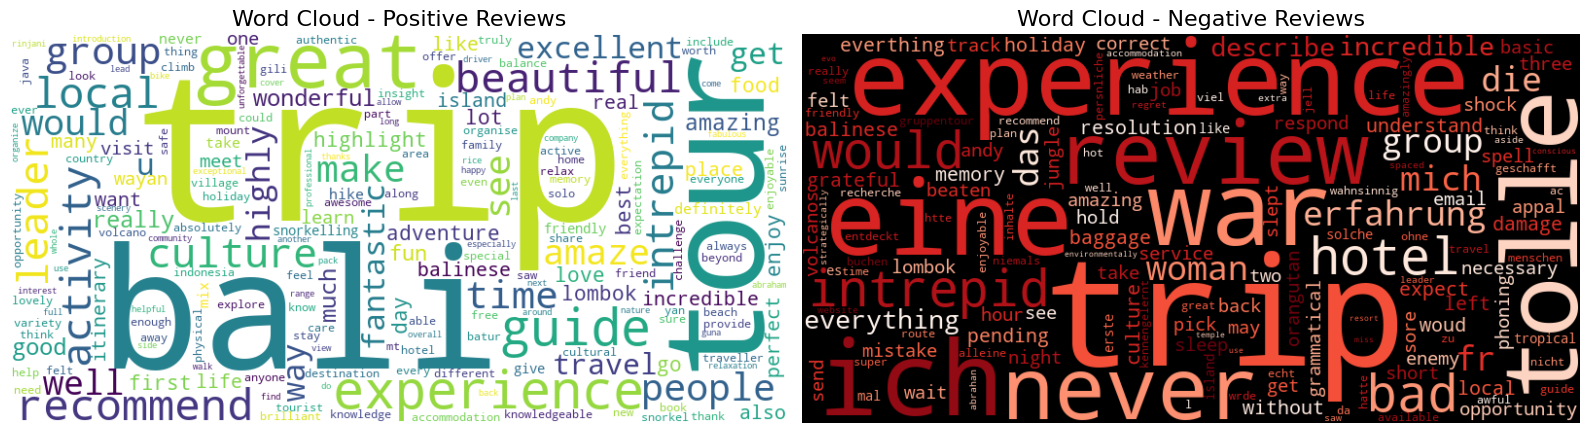

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# Baca data hasil pelabelan
data = pd.read_csv('dataset/datalabelintrepidtravel.csv')

#Lakukan tokenisasi
data['komen'] = data["komen"].apply(tokenize_text)

#Fungsi untuk menghitung frekuensi kata
def word_frequencies_by_label(df, label):
    subset = df[df['label'] == label]
    all_tokens = []
    for tokens in subset['komen']:
        all_tokens.extend(tokens)
    return Counter(all_tokens)

# Hitung frekuensi kata untuk setiap kelas
freq_positive = word_frequencies_by_label(data, 'positive')
freq_negative = word_frequencies_by_label(data, 'negative')

# Buat WordCloud untuk data positif
wc_positive = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_positive)

# Buat WordCloud untuk data negatif
wc_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate_from_frequencies(freq_negative)

# Tampilkan WordCloud
plt.figure(figsize=(16, 8))

# WordCloud Positif
plt.subplot(1, 2, 1)
plt.imshow(wc_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Reviews', fontsize=16)
plt.axis('off')

# WordCloud Negatif
plt.subplot(1, 2, 2)
plt.imshow(wc_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Reviews', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

# Konversi ke DataFrame
df_positive = pd.DataFrame(freq_positive.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)
df_negative = pd.DataFrame(freq_negative.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Simpan ke CSV
df_positive.to_csv('dataset/frekuensi_positive_tokenized2.csv', index=False)
df_negative.to_csv('dataset/frekuensi_negative_tokenized2.csv', index=False)
